# Flattener

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import skimage.external.tifffile as tif
import scipy.signal
import scipy.ndimage as ndi
import tqdm

In [2]:
# data has been downsampled by a factor of 8 in each dimension to give 64 nm voxels.
data = tif.imread("testdata.tif")

In [3]:
plt.set_cmap("Greys")

<Figure size 432x288 with 0 Axes>

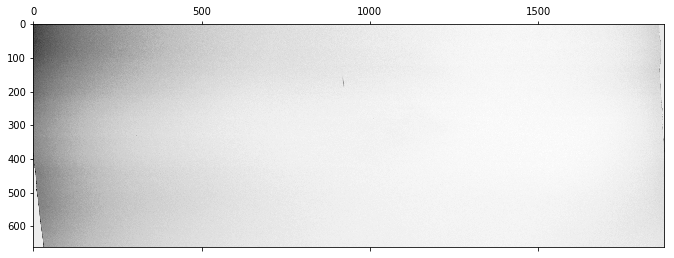

In [4]:
plt.matshow(data[:, 0, :])

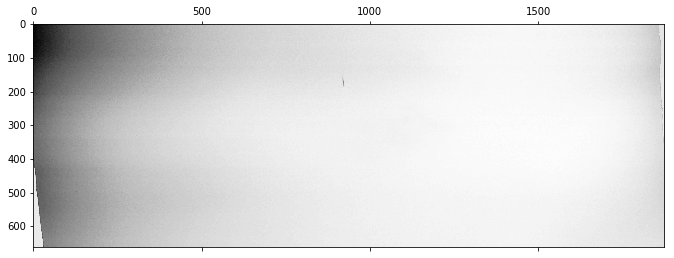

In [6]:
flat_field = data[:, 0, :]
flat_field = ndi.median_filter(flat_field, 3)
# flat_field = ndi.gaussian_filter(flat_field, 21)
plt.matshow(flat_field)

In [7]:
data_norm = (data - (flat_field - np.median(flat_field))[:, None].astype("int")).astype("uint8")

In [8]:
tif.imsave("testdatanorm.tif", data_norm, compress=6)

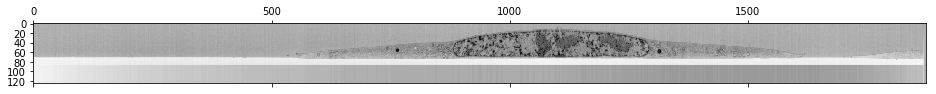

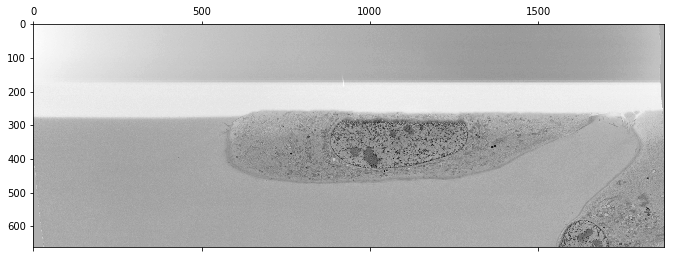

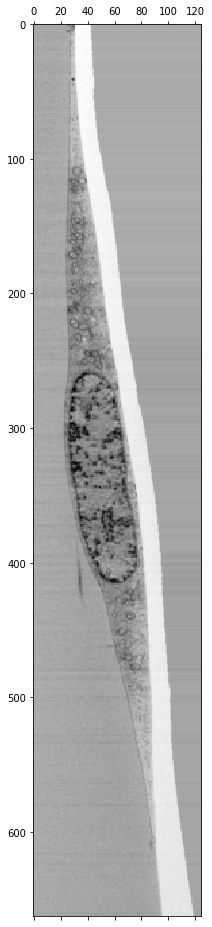

In [9]:
# ortho slices through the center
center = np.asarray(data.shape) // 2
for i, c in enumerate(center):
    s = [slice(None)] * 3
    s[i] = c
    plt.matshow(data_norm[s])

In [10]:
def find_max_line(d, max_percentage=0.25, win=11, order=3, poly=3, diagnostics=False):
    if max_percentage < 0.0:
        return np.nan
    deriv = scipy.signal.savgol_filter(d * 1.0, win, poly, 1)
    deriv[abs(deriv) < abs(deriv).max() * max_percentage] = 0
    mins = scipy.signal.argrelmin(deriv, order=order)[0]
    if diagnostics:
        fig, (ax0, ax1) = plt.subplots(2)
        ax0.plot(d)
        ax1.plot(deriv)
        for m in mins:
            for ax in (ax0, ax1):
                ax.axvline(m)
    if len(mins):
        return mins[-1]
    else:
        return find_max_line(d, max_percentage=max_percentage - 0.05, win=win, order=order, poly=poly, diagnostics=diagnostics)

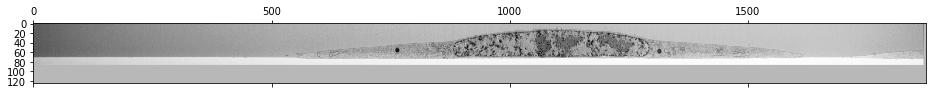

In [11]:
plt.matshow(data[330])

numpy.int64

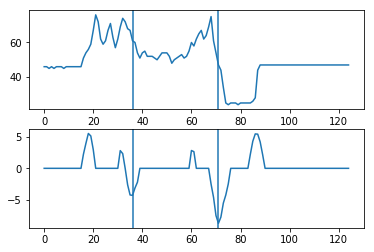

In [12]:
type(find_max_line(data[330, :, 1002], diagnostics=True))

74

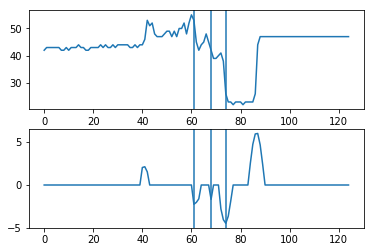

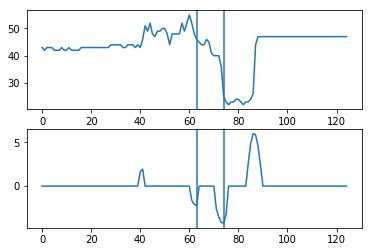

In [13]:
find_max_line(data[330, :, 1390], diagnostics=True)
find_max_line(data[330, :, 1391], diagnostics=True)

In [14]:
def find_max_plane(d, max_percentage=0.2):
    return np.array([find_max_line(dd, max_percentage) for dd in d.T])

In [15]:
%time a = np.array(find_max_plane(data[330]))

CPU times: user 1.2 s, sys: 24.2 ms, total: 1.22 s
Wall time: 1.16 s


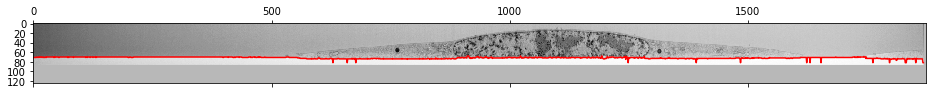

In [16]:
# s = slice(1390, 1400)
s = slice(None)
plt.matshow(data[330,:,s], cmap="Greys")
plt.plot(a[s], "r")

In [17]:
import tqdm

In [18]:
result = np.array([find_max_plane(d) for d in tqdm.tqdm(data)])

100%|██████████| 663/663 [11:07<00:00,  1.01s/it]


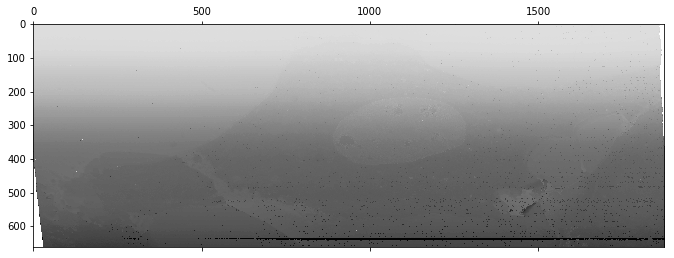

In [19]:
plt.matshow(result)

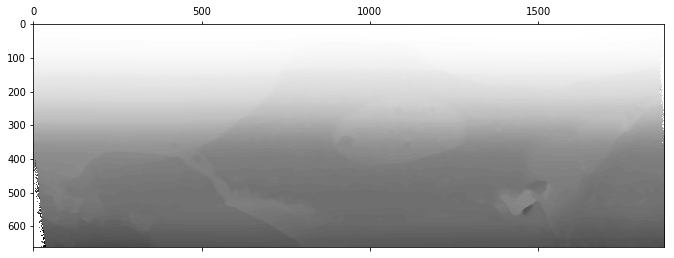

In [43]:
plt.matshow(scipy.ndimage.median_filter(result, 17))

## Plan

There are two types of issues, those do to the `SIFT` alignment algorithm and those do to actual physical problems, i.e. when removing the coverslip. There may also be a general rotation.

Therefore we have the following plan
1. find edge
2. Deal with SIFT first:
    1. Find best rotation angle
    2. Subtract trend perpendicular to milling direction
3. Deal with further warping:
    1. rolling ball filter remaining baseline
    2. rotate (if necessary)
    3. remove baseline

In [21]:
tif.imsave("64x64x64nm_baseline.tif", result, compress=6)

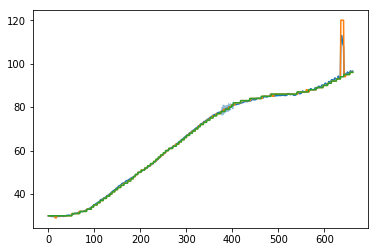

In [44]:
bm = np.nanmean(result, 1)
bm2 = np.nanmedian(result, 1)
bm3 = np.nanmedian(scipy.ndimage.median_filter(result, 17), 1)
bs = result.std(1)
x = np.arange(bs.size)
plt.fill_between(x, bm - bs, bm + bs, alpha=0.5)

plt.plot(x, bm)
plt.plot(x, bm2)
plt.plot(x, bm3)

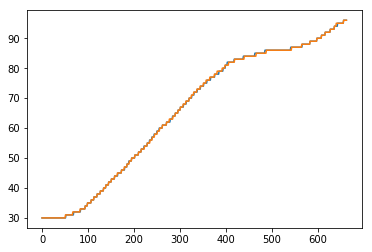

In [45]:
bm4 = scipy.ndimage.median_filter(bm2, 15)
plt.plot(bm3)
plt.plot(bm4)

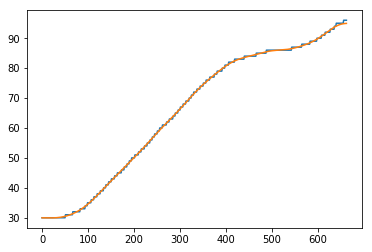

In [24]:
fig, ax = plt.subplots()
ax.plot(bm3)
bm4 = scipy.signal.filtfilt(*scipy.signal.butter(3, 0.025), bm3)
ax.plot(bm4)
# ax.set_aspect(1)

In [25]:
x = np.arange(len(bm4))
s = slice(150, 350)
b, m = np.polyfit(x[s], bm4[s], 1)
np.rad2deg(np.arctan(b))

9.22242012360944

In [26]:
theta = np.arctan(b)
x0, y0 = x.mean(), bm4.mean()
xc, yc = x - x0, bm4 - y0
xp, yp = xc * np.cos(theta) + yc * np.sin(theta), -xc * np.sin(theta) + yc * np.cos(theta)
xp += x0
yp += y0

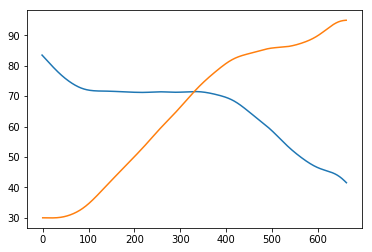

In [27]:
plt.plot(xp, yp)
plt.plot(x, bm4)

In [28]:
def rotmatrix(angle):
    """Generate a rotation matrix"""
    return np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])

def apply(transform, coords):
    """Apply a matrix transformation to the coordinates"""
    return np.tensordot(transform, coords, axes=1)

In [29]:
data.shape

(663, 125, 1875)

In [30]:
coords = np.indices(data.shape[:2])
center = center = np.array(data.shape[:2])[:, None, None] // 2
center

array([[[331]],

       [[ 62]]])

In [31]:
coords2 = apply(rotmatrix(-theta), coords - center) + center

In [32]:
img = data_norm[..., 1875 // 2]
def plot_coords(coords):
    """show the coordinates and the warped image"""
    fig, ((g00, g01), (g10, g11)) = fig, grid = plt.subplots(2, 2, figsize=(20,4))
    
    # show coordinates
    g00.matshow(coords[0].T)
    g00.contour(coords[0].T, colors="k")
    g00.set_title("Y coordinate")
    g01.matshow(coords[1].T)
    g01.contour(coords[1].T, colors="k")
    g01.set_title("X coordinate")
    
    # show images
    img2 = ndi.map_coordinates(img, coords)
    g10.matshow(img.T)
    g10.set_title("Original Image")
    g11.matshow(img2.T)
    g11.set_title("Warped Image")
    
    for g in grid.ravel():
        g.axis("off")
        
    return img2

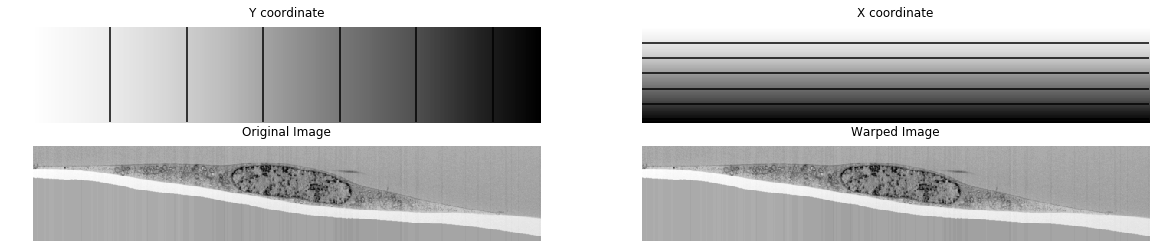

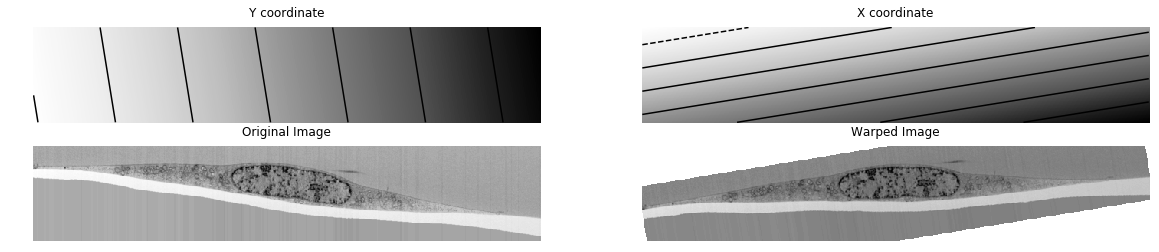

In [33]:
plot_coords(coords);
plot_coords(coords2);

In [34]:
import scipy.interpolate as interpolate

In [35]:
myint = interpolate.interp1d(xp, yp - yp.mean(), bounds_error=False)

In [36]:
coords3 = np.array((coords2[0], coords2[1] + myint(coords2[0])))

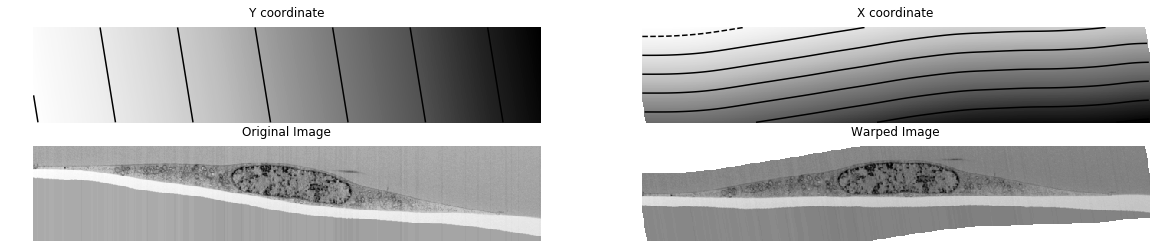

In [37]:
plot_coords(coords3);

In [38]:
data_norm_flatten = np.array([ndi.map_coordinates(d, coords3) for d in tqdm.tqdm(np.rollaxis(data_norm, -1))])

100%|██████████| 1875/1875 [00:22<00:00, 82.25it/s]


In [39]:
tif.imsave("testdatanorm_flat.tif", np.rollaxis(data_norm_flatten, 0, data_norm_flatten.ndim), compress=6)

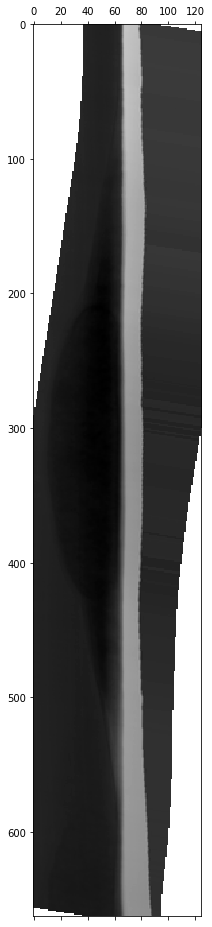

In [49]:
plt.matshow(np.mean(data_norm_flatten[100:-100], 0))

In [51]:
(np.array(data.shape) * 8).prod()

79560000000